# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"


In [2]:
import jax
import jax.numpy as jnp
import jax_galsim as xgalsim
import matplotlib.pyplot as plt 

from jax import random
from jax import vmap, grad, jit

import galsim

In [3]:
def render_bd(
    lfb, lfd, r0b, hlrd, qb, qd, beta, x, y, *, psf_hlr=0.7, slen=63, fft_size=256, pixel_scale=0.2
):
    gsparams = xgalsim.GSParams(minimum_fft_size=fft_size, maximum_fft_size=fft_size)

    flux_b = 10**lfb
    flux_d = 10**lfd
    
    components = []
    
    disk = xgalsim.Exponential(flux=flux_d, half_light_radius=hlrd).shear(
        q=qd,
        beta=beta * xgalsim.radians,
    )
    components.append(disk)

    bulge = xgalsim.Spergel(nu=-0.6, flux=flux_b, scale_radius=r0b).shear(
        q=qb,
        beta=beta * xgalsim.radians,
    )
    components.append(bulge)

    galaxy = xgalsim.Add(components)    
    psf = xgalsim.Gaussian(flux=1.0, half_light_radius=0.7)
    gal_conv = xgalsim.Convolve([galaxy, psf]).withGSParams(gsparams)
    galaxy_image = gal_conv.drawImage(nx=slen, ny=slen, scale=pixel_scale, offset=(x,y)).array
    return galaxy_image

In [4]:
def render_bd_galsim(
    lfb, lfd, r0b, hlrd, qb, qd, beta, x, y, *, psf_hlr=0.7, slen=63, pixel_scale=0.2
):

    flux_b = 10**lfb
    flux_d = 10**lfd

    
    components = []
    
    disk = galsim.Exponential(flux=flux_d, half_light_radius=hlrd).shear(
        q=qd,
        beta=beta * galsim.radians,
    )
    components.append(disk)

    bulge = galsim.Spergel(nu=-0.6, flux=flux_b, scale_radius=r0b).shear(
        q=qb,
        beta=beta * galsim.radians,
    )
    components.append(bulge)

    galaxy = galsim.Add(components)    
    psf = galsim.Gaussian(flux=1.0, half_light_radius=0.7)
    gal_conv = galsim.Convolve([galaxy, psf])
    galaxy_image = gal_conv.drawImage(nx=slen, ny=slen, scale=pixel_scale, offset=(x,y)).array
    return galaxy_image, gal_conv.getGoodImageSize(0.2)

In [5]:
from bpd.noise import add_noise 

def get_target_images(
    rng_key,
    galaxy_params,
    *,
    background: float,
    slen: int,
):
    """Single noise realization of multiple galaxies (GalSim)."""
    n_gals = galaxy_params["lfb"].shape[0]
    nkeys = random.split(rng_key, n_gals)

    target_images = []
    for ii in range(n_gals):
        _params = {k: v[ii].item() for k, v in galaxy_params.items()}
        noiseless = render_bd_galsim(**_params, slen=slen)[0]
        target_image = add_noise(nkeys[ii], noiseless, bg=background, n=1)
        assert target_image.shape == (1, slen, slen)
        target_images.append(target_image)

    return jnp.concatenate(target_images, axis=0)

# Timing comparisons

In [8]:
render_bd_jit = jax.jit(render_bd)
_ = render_bd_jit(5., 5., 0.75, 0.75, 0.5, 0.5,jnp.pi/4, 0, 0)

In [23]:
%%timeit 
render_bd_jit(5., 5., 0.75, 0.75, 0.5, 0.5,jnp.pi/4, 0, 0) # faster than GalSim in GPU!

256 μs ± 1.99 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
%%timeit 
render_bd_galsim(5., 5., 0.75, 0.75, 0.5, 0.5,jnp.pi/4, 0, 0)[0]

507 μs ± 13.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
im1 = render_bd_jit(5., 5., 0.75, 0.75, 0.5, 0.5,jnp.pi/4, 0, 0)
im2 = render_bd_galsim(5., 5., 0.75, 0.75, 0.5, 0.5,jnp.pi/4, 0, 0)[0]

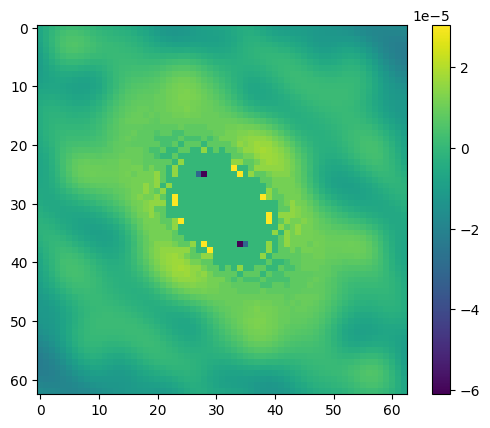

In [26]:
plt.imshow(im1 - im2)
plt.colorbar()

In [27]:
from bpd.draw import draw_gaussian
from functools import partial
draw_fnc = jax.jit(partial(draw_gaussian, slen=63, fft_size=256, ))
_ = draw_fnc(f=100.0, hlr=1.0, e1=0.2, e2=0.2,x=0.0, y=0.0);


In [28]:
%timeit draw_fnc(f=100.0, hlr=1.0, e1=0.2, e2=0.2,x=0.0, y=0.0); # slightly slower then Gaussian


200 μs ± 1.25 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
# what size? 
render_bd_galsim(5., 5., 0.9, 0.9, 0.5, 0.5, jnp.pi/4, 0, 0)[1]

74

# Sampling

In [30]:
def bd_prior(rng_key):
    keys = random.split(rng_key, 10)
    lfd = random.uniform(keys[0], minval=5.5, maxval=6)
    lfb = random.uniform(keys[1], minval=5.5, maxval=6)

    hlrd = random.uniform(keys[2], minval=0.8, maxval=0.9)
    r0b = random.uniform(keys[3], minval=0.8, maxval=0.9)
    
    qb = random.uniform(keys[4], minval=0.1, maxval=0.9)
    qd = random.uniform(keys[5], minval=0.1, maxval=0.9)

    beta = random.uniform(keys[6], minval=0, maxval= 2 * jnp.pi)

    x, y = random.uniform(keys[7], shape=(2,), minval=-0.5, maxval=0.5)

    return {'lfb':lfb, 'lfd':lfd, 'hlrd':hlrd, 'r0b':r0b, 'qb':qb, 'qd':qd, 'beta':beta, 'x':x, 'y':y}


In [31]:
# interim prior
from jax import Array
from typing import Callable
from jax.scipy import stats

def logprior(
    params: dict[str, Array],
    *,
    sigma_x: float = 0.5,  # pixels
) -> Array:
    prior = jnp.array(0.0)

    prior += stats.uniform.logpdf(params["lfb"], -1, 10)
    prior += stats.uniform.logpdf(params["lfd"], -1, 10)
    prior += stats.uniform.logpdf(params["r0b"], 0.01, 5.0)
    prior += stats.uniform.logpdf(params["hlrd"], 0.01, 5.0)

    prior += stats.uniform.logpdf(params["qb"], 0.01, 0.99)
    prior += stats.uniform.logpdf(params["qd"], 0.01, 0.99)
    prior += stats.uniform.logpdf(params["beta"], 0, 2 * jnp.pi)
    
    prior += stats.norm.logpdf(params["x"], loc=0.0, scale=sigma_x)
    prior += stats.norm.logpdf(params["y"], loc=0.0, scale=sigma_x)

    return prior


def loglikelihood(
    params: dict[str, Array],
    data: Array,
    *,
    draw_fnc: Callable,
    background: float,
):
    # NOTE: draw_fnc should already contain `f` and `hlr` as constant arguments if fixed
    model = draw_fnc(**params)
    likelihood_pp = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(background))
    return jnp.sum(likelihood_pp)


def logtarget(
    params: dict,
    data: Array,
    *,
    logprior_fnc: Callable,
    loglikelihood_fnc: Callable,
):
    return logprior_fnc(params) + loglikelihood_fnc(params, data)

In [95]:
rng_key = random.key(42) 
k1, k2, k3= random.split(rng_key, 3)

In [96]:
gal_params =vmap(bd_prior)(random.split(k1, 1))
gal_params

{'beta': Array([5.18025632], dtype=float64),
 'hlrd': Array([0.87064839], dtype=float64),
 'lfb': Array([5.52325042], dtype=float64),
 'lfd': Array([5.80927813], dtype=float64),
 'qb': Array([0.70603094], dtype=float64),
 'qd': Array([0.44899963], dtype=float64),
 'r0b': Array([0.8681269], dtype=float64),
 'x': Array([-0.11151964], dtype=float64),
 'y': Array([-0.12520296], dtype=float64)}

In [97]:
images = get_target_images(k2, gal_params, background=1.0, slen=73)
images.shape

(1, 73, 73)

In [98]:
# setup for NUTS
from functools import partial
_draw_fnc  = jit(partial(render_bd, slen=73, fft_size=292))
_logprior = logprior
_loglikelihood = partial(loglikelihood, draw_fnc=_draw_fnc, background=1.0)
_logtarget = partial(logtarget, logprior_fnc=_logprior, loglikelihood_fnc =_loglikelihood)

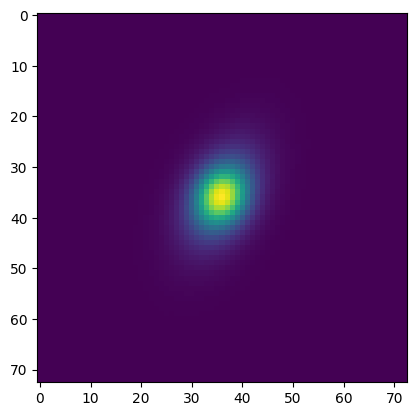

In [99]:
plt.imshow(images[0])

In [100]:
from bpd.chains import run_inference_nuts

## Preliminary Timing

In [40]:
_run_inference = jit(partial(run_inference_nuts, logtarget=_logtarget, n_samples=1, initial_step_size=0.1, 
                             max_num_doublings=5, is_mass_matrix_diagonal=True, n_warmup_steps=100))


In [41]:
%time samples = vmap(_run_inference)(random.split(k3, 1), gal_params, images) # compile

CPU times: user 16.7 s, sys: 1.18 s, total: 17.9 s
Wall time: 17.5 s


In [42]:
%time samples = vmap(_run_inference)(random.split(k3, 1), gal_params, images) # timing

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


## Contours

In [128]:
_run_inference = vmap(jit(partial(run_inference_nuts, logtarget=_logtarget, n_samples=500, initial_step_size=0.01, 
                             max_num_doublings=7, is_mass_matrix_diagonal=True, n_warmup_steps=500)))

In [129]:
samples = _run_inference(random.split(k3, 1), gal_params, images)

In [130]:
gal_params.keys()

dict_keys(['beta', 'hlrd', 'lfb', 'lfd', 'qb', 'qd', 'r0b', 'x', 'y'])

In [131]:
samples.keys()

dict_keys(['beta', 'hlrd', 'lfb', 'lfd', 'qb', 'qd', 'r0b', 'x', 'y'])

In [132]:
# gal_params['hlrd'], samples['hlrd']

In [133]:
import numpy as np 

In [134]:
_samples = {k:np.array(v)[0] for k,v in samples.items()}

In [135]:
for k,v in _samples.items():
    print(k, v.shape, v.dtype)

beta (500,) float64
hlrd (500,) float64
lfb (500,) float64
lfd (500,) float64
qb (500,) float64
qd (500,) float64
r0b (500,) float64
x (500,) float64
y (500,) float64


Parameter beta in chain posterior is not constrained
Parameter lfd in chain posterior is not constrained
Parameter y in chain posterior is not constrained


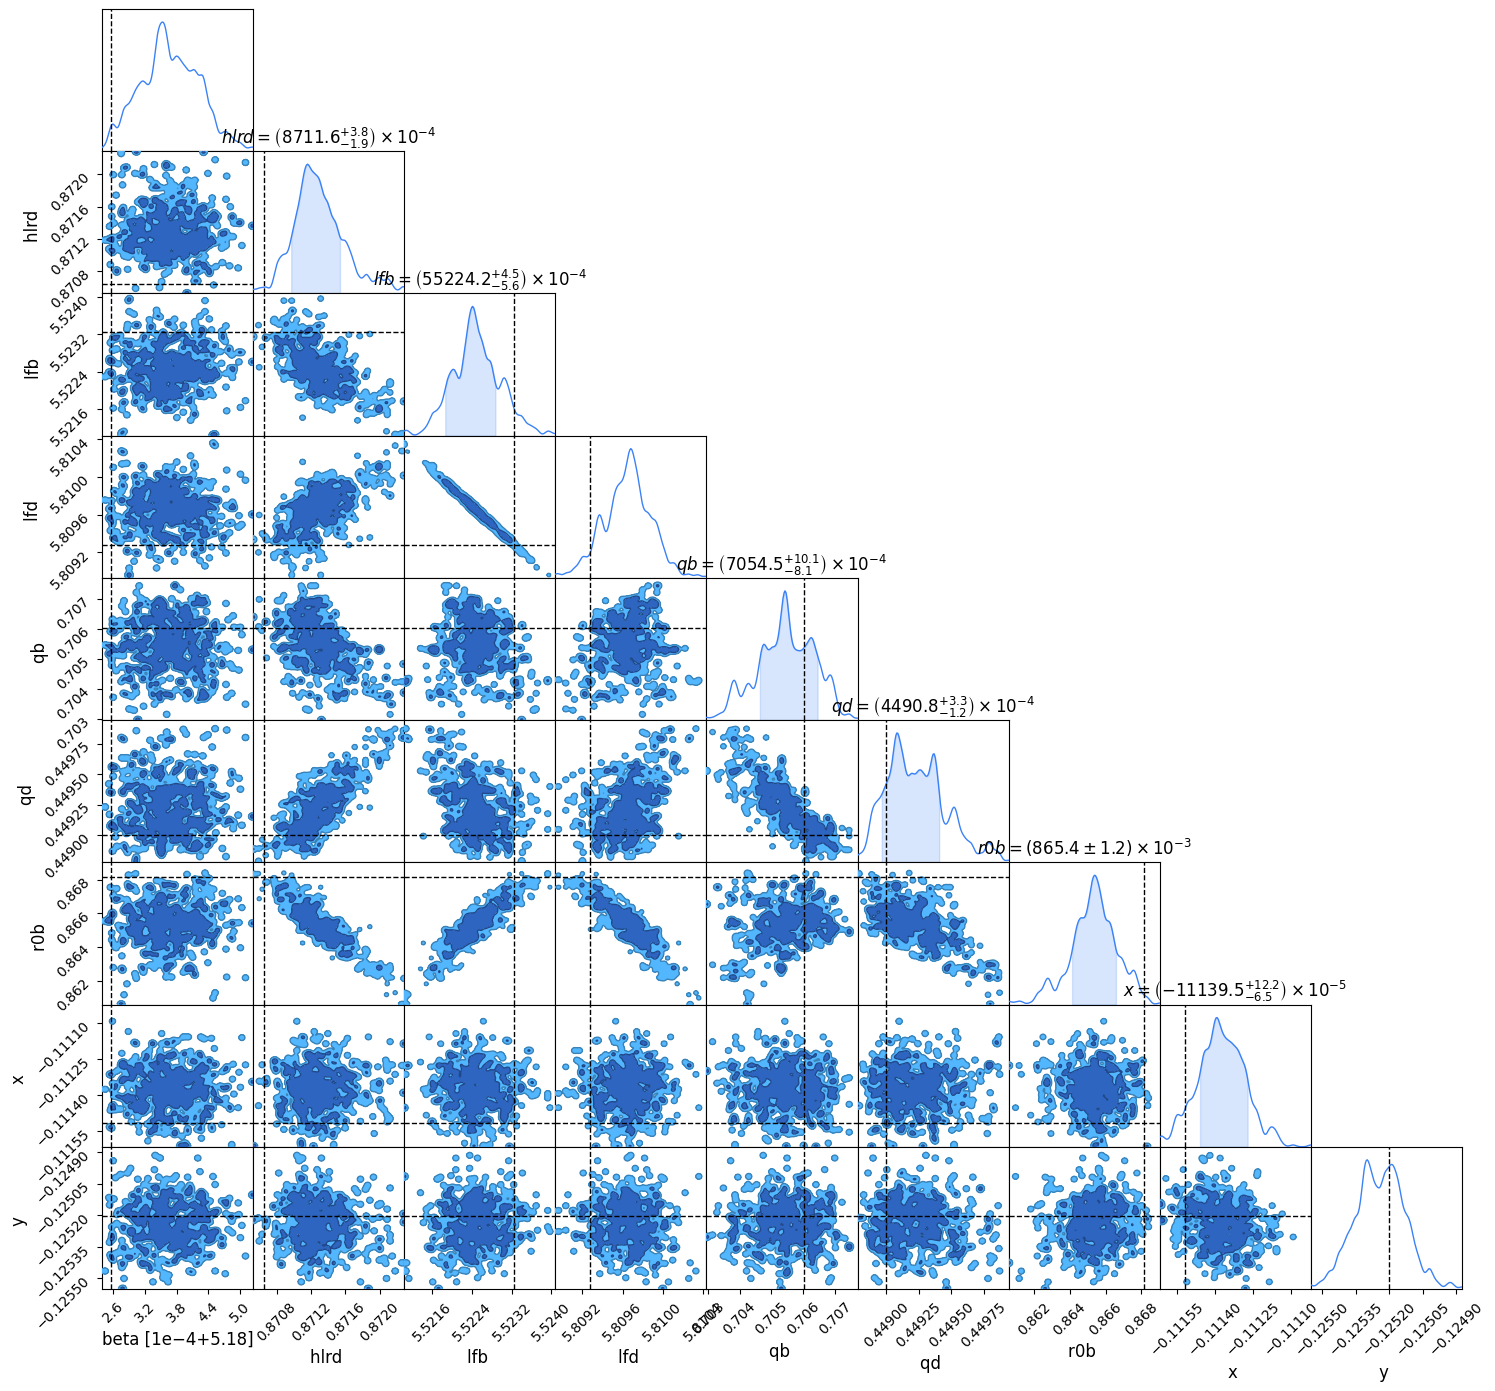

In [136]:
from bpd.diagnostics import get_contour_plot
_ = get_contour_plot([_samples], ['posterior'], {k:v.item() for k,v in gal_params.items()}, figsize=(16,16))

In [137]:
samples['hlrd'].shape

(1, 500)

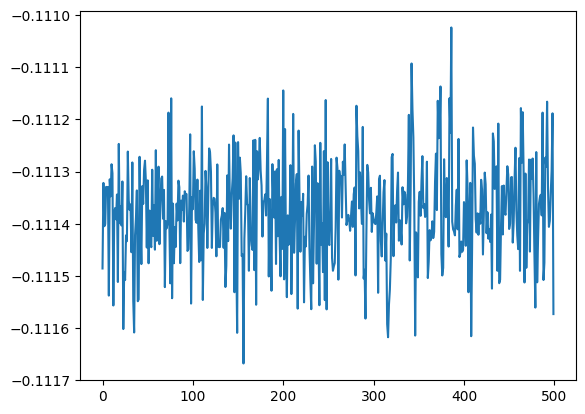

In [138]:
plt.plot(samples['x'][0])

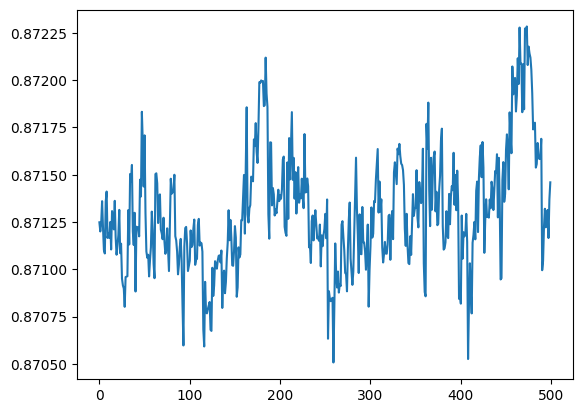

In [139]:
# trace 
plt.plot(samples['hlrd'][0])

In [140]:
# timing (one chain) (after compilation)
%time _ = _run_inference(random.split(k3, 1), gal_params, images)

CPU times: user 29.2 s, sys: 0 ns, total: 29.2 s
Wall time: 29.2 s


## Timing, more galaxies

In [77]:
rng_key = random.key(42) 
k1, k2, k3= random.split(rng_key, 3)

n_gals = 50

In [79]:
gal_params =vmap(bd_prior)(random.split(k1, n_gals))
gal_params['lfb'].shape

(50,)

In [80]:
images = get_target_images(k2, gal_params, background=1.0, slen=73)
images.shape

(50, 73, 73)

In [83]:
_run_inference = vmap(jit(partial(run_inference_nuts, logtarget=_logtarget, n_samples=100, initial_step_size=0.1, 
                             max_num_doublings=5, is_mass_matrix_diagonal=True, n_warmup_steps=500)))

In [84]:
%time _ = _run_inference(random.split(k3, 1), {k:v[0, None] for k,v in gal_params.items()}, images[0, None]) # compile time, one chain

CPU times: user 21.2 s, sys: 1.04 s, total: 22.2 s
Wall time: 22.1 s


In [85]:
%time _ = _run_inference(random.split(k3, 1), {k:v[0, None] for k,v in gal_params.items()}, images[0, None]) # runtime, one chain

CPU times: user 6.1 s, sys: 15.6 ms, total: 6.11 s
Wall time: 6.11 s


In [86]:
%time _ = _run_inference(random.split(k3, n_gals), gal_params, images) # runtime, 50 chains

CPU times: user 1min 5s, sys: 980 ms, total: 1min 6s
Wall time: 1min 4s
